In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_simple_network, Flatten, weight_reset

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [3]:
torch.backends.cudnn.deterministic=True
from idlmam import set_seed, moveTo
set_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
    
mnist_train_loader = DataLoader(mnist_data_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=64)

#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#Hidden layer size
n = 256 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

#Create our regular model 
model_regular = nn.Sequential(
  Flatten(), 
  nn.Linear(D, n), 
  nn.Tanh(),
  nn.Linear(n, n), 
  nn.Tanh(),
  nn.Linear(n, n), 
  nn.Tanh(),
  nn.Linear(n, classes),
)

In [7]:
loss_func = nn.CrossEntropyLoss()
regular_results = train_simple_network(model_regular, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

In [8]:
#Create the layer of weights of our network that we plan to share. 
h_2 = nn.Linear(n, n)
model_shared = nn.Sequential(
  Flatten(), 
  nn.Linear(D, n), 
  nn.Tanh(),
  h_2, #First use
  nn.Tanh(),
  h_2, #Second use, now sharing the weights
  nn.Tanh(),
  nn.Linear(n, classes),
)

In [9]:
shared_results = train_simple_network(model_shared, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

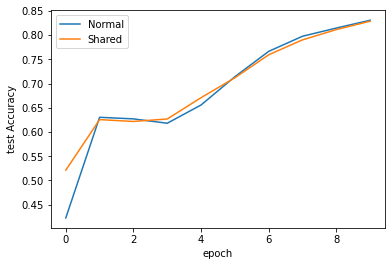

In [10]:
#Now we can plot the results, and compare them
sns.lineplot(x='epoch', y='test Accuracy', data=regular_results, label='Normal')
sns.lineplot(x='epoch', y='test Accuracy', data=shared_results, label='Shared')

In [11]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

In [12]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [13]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

In [14]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [15]:
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)
    print(input_sequence.shape, x_seq.shape)
    print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[ 0.7626,  0.1343],
        [ 1.5189,  0.6567],
        [ 1.5189,  0.6567],
        [ 0.7626,  0.1343],
        [-0.5718,  0.2879]])


In [16]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple, 
            last_step = last_step[0]#then h_t is the first item in the tuple
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate 
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [17]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

In [18]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5)

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

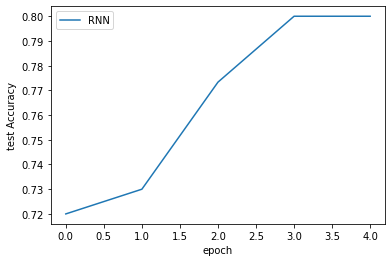

In [19]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='RNN')

In [20]:
pred_rnn = first_rnn.to("cpu").eval()
with torch.no_grad():
    preds = F.softmax(pred_rnn(dataset.string2InputVec("frank").reshape(1,-1)), dim=-1)
    for class_id in range(len(dataset.label_names)):
        print(dataset.label_names[class_id], ":", preds[0,class_id].item()*100 , "%")

Arabic : 0.002683540151338093 %
Chinese : 0.2679025521501899 %
Czech : 10.59301644563675 %
Dutch : 7.299012690782547 %
English : 36.81915104389191 %
French : 0.5335223395377398 %
German : 37.42799460887909 %
Greek : 0.018611310224514455 %
Irish : 0.7783998735249043 %
Italian : 1.1141937226057053 %
Japanese : 0.00488687728648074 %
Korean : 0.421459274366498 %
Polish : 1.1676722206175327 %
Portuguese : 0.08807195699773729 %
Russian : 1.2793921865522861 %
Scottish : 1.6346706077456474 %
Spanish : 0.14639737782999873 %
Vietnamese : 0.40296311490237713 %


In [21]:
def pad_and_pack(batch):
    #1, 2, & 3: organize the batch input lengths, inputs, and outputs as seperate lists
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    #4: create the padded version of the input
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    #Convert the lengths into a tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)
    #6: return a tuple of the packed inputs and their labels
    return x_packed, y_batched


In [22]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects. 
    This wrapper class will fix that. If a normal input comes in, it will 
    use the regular Embedding layer. Otherwise, it will work on the packed 
    sequence to return a new Packed sequence of the appropriate result. 
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)


In [23]:
B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

In [24]:
rnn_packed = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_packed.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=256, out_features=18, bias=True)
)

In [25]:
packed_train = train_simple_network(rnn_packed, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

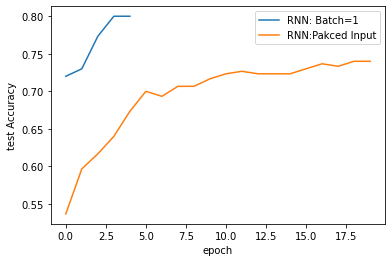

In [26]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='RNN: Batch=1')
sns.lineplot(x='epoch', y='test Accuracy', data=packed_train, label='RNN:Pakced Input')

<AxesSubplot:xlabel='total time', ylabel='test Accuracy'>

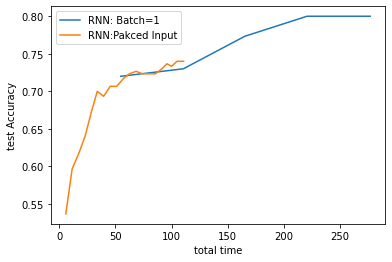

In [27]:
sns.lineplot(x='total time', y='test Accuracy', data=batch_one_train, label='RNN: Batch=1')
sns.lineplot(x='total time', y='test Accuracy', data=packed_train, label='RNN:Pakced Input')

In [28]:
pred_rnn = rnn_packed.to("cpu").eval()

with torch.no_grad():
    preds = F.softmax(pred_rnn(dataset.string2InputVec("frank").reshape(1,-1)), dim=-1)
    for class_id in range(len(dataset.label_names)):
        print(dataset.label_names[class_id], ":", preds[0,class_id].item()*100 , "%")

Arabic : 0.586722744628787 %
Chinese : 0.5682710558176041 %
Czech : 15.79725593328476 %
Dutch : 5.215919017791748 %
English : 42.07158088684082 %
French : 1.7968742176890373 %
German : 13.949412107467651 %
Greek : 0.40299338288605213 %
Irish : 2.425672672688961 %
Italian : 5.216174945235252 %
Japanese : 0.3031977219507098 %
Korean : 0.7202120032161474 %
Polish : 2.772565931081772 %
Portuguese : 0.9149040095508099 %
Russian : 4.370814561843872 %
Scottish : 1.0111995041370392 %
Spanish : 1.2703102082014084 %
Vietnamese : 0.6059217266738415 %


In [29]:
rnn_3layer = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_3layer.to(device)
rnn_3layer_results = train_simple_network(rnn_3layer, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20, lr=0.01)

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

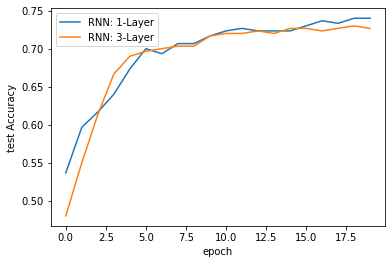

In [30]:
sns.lineplot(x='epoch', y='test Accuracy', data=packed_train, label='RNN: 1-Layer')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_results, label='RNN: 3-Layer')

In [31]:
rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)
rnn_3layer_bidir_results = train_simple_network(rnn_3layer_bidir, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20, lr=0.01)

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

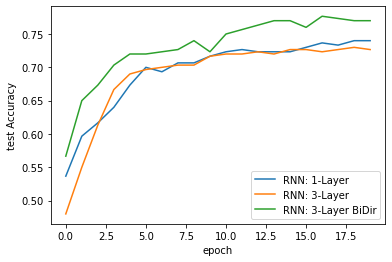

In [32]:
sns.lineplot(x='epoch', y='test Accuracy', data=packed_train, label='RNN: 1-Layer')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_results, label='RNN: 3-Layer')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_results, label='RNN: 3-Layer BiDir')